# Install dependencies

In [ ]:
!pip install --upgrade torch #torchtext
!pip install torchtext==0.6.0

In [ ]:
!pip install nltk swifter livelossplot

In [ ]:
!pip install allennlp

# Initialize

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm.notebook import tqdm

import pandas as pd
pd.options.display.max_colwidth = 150

torch.manual_seed(1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
from joblib import Memory


CACHE_DIR = 'cache'
if not os.path.isdir(CACHE_DIR):
    os.mkdir(CACHE_DIR)

MEMORY = Memory(CACHE_DIR, verbose=0)

# Load and preprocess the corpus annotated with sentiment

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls 'gdrive/MyDrive/Colab Notebooks/data'

Mounted at /content/gdrive
yelp_review_polarity_csv  yelp_review_polarity_csv.tar.gz


In [17]:
import torchtext
from torchtext.utils import download_from_url, extract_archive

# datasets = {
#     'yelp_review_polarity_csv' : 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbNUpYQ2N3SGlFaDg',
#     'yelp_review_full_csv' : 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbZlU4dXhHTFhZQU0',
#     'amazon_review_polarity_csv' : 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM',
#     'amazon_review_full_csv': 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA'
# }

# DATA_PATH = 'data'
# if not os.path.isdir(DATA_PATH):
#     os.mkdir(DATA_PATH)

dataset_name = 'yelp_review_polarity_csv'

# dataset_tar = download_from_url(datasets[dataset_name], root=DATA_PATH)
# extracted_files = extract_archive(dataset_tar)

DATA_PATH = 'gdrive/MyDrive/Colab Notebooks/data/'
extracted_files = extract_archive('gdrive/MyDrive/Colab Notebooks/data/yelp_review_polarity_csv.tar.gz')
extracted_files

['gdrive/MyDrive/Colab Notebooks/data/yelp_review_polarity_csv/readme.txt',
 'gdrive/MyDrive/Colab Notebooks/data/yelp_review_polarity_csv/test.csv',
 'gdrive/MyDrive/Colab Notebooks/data/yelp_review_polarity_csv/train.csv']

In [11]:
pd.read_csv(extracted_files[1], header=None, names=['label', 'text']).head()

,label,text
0,2,"Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now,..."
1,1,Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with...
2,2,"Friendly staff, same starbucks fair you get anywhere else. Sometimes the lines can get long."
3,1,"The food is good. Unfortunately the service is very hit or miss. The main issue seems to be with the kitchen, the waiters and waitresses are often..."
4,2,Even when we didn't have a car Filene's Basement was worth the bus trip to the Waterfront. I always find something (usually I find 3-4 things and ...


In [12]:
from nltk.tokenize import TweetTokenizer
import swifter
from torchtext.vocab import Vocab
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from pathlib import Path


def create_vocab(dataset):
    counter = Counter()
    for inst in dataset:
        counter.update(inst)

    return Vocab(counter, min_freq=1)


def vectorize_dataset(dataset, vocab):
    result = []
    for example in dataset:
        result.append([vocab[t] for t in example])
    return result


@MEMORY.cache
def preprocess_dataset(data_path, max_train, max_test, max_dev, random_state=1981):
    columns = ['label', 'text']
    test_df = pd.read_csv(Path(data_path) / 'test.csv', header=None, names=columns)
    train_df = pd.read_csv(Path(data_path) / 'train.csv', header=None, names=columns)

    test_df = test_df.sample(n=max_test, random_state=random_state)
    train_df = train_df.sample(n=max_dev + max_train, random_state=random_state)

    dev_df = train_df[max_train:]
    train_df = train_df[:max_train]

    tokenizer = TweetTokenizer()
    def ling_preprocess(text):
        # TODO: add lemmatization
        # TODO: add bigrams
        return [e.lower() for e in tokenizer.tokenize(text)]

    train_text_preproc = train_df.text.swifter.apply(ling_preprocess)
    test_text_preproc = test_df.text.swifter.apply(ling_preprocess)
    dev_text_preproc = dev_df.text.swifter.apply(ling_preprocess)

    vocab = create_vocab(train_text_preproc)

    train_token_ids = vectorize_dataset(train_text_preproc, vocab)
    test_token_ids = vectorize_dataset(test_text_preproc, vocab)
    dev_token_ids = vectorize_dataset(dev_text_preproc, vocab)

    label_encoder = LabelEncoder()
    train_label_ids = label_encoder.fit_transform(train_df.label)
    test_label_ids = label_encoder.transform(test_df.label)
    dev_label_ids = label_encoder.transform(dev_df.label)

    train_dataset = list(zip(train_label_ids, train_token_ids))
    dev_dataset = list(zip(dev_label_ids, dev_token_ids))
    test_dataset = list(zip(test_label_ids, test_token_ids))

    return (vocab, label_encoder), (train_dataset, test_dataset, dev_dataset), (train_df, test_df, dev_df)

In [18]:
vocab_label_enc, vectorized_datasets, text_datasets = preprocess_dataset(data_path=Path(DATA_PATH) / dataset_name,
                                                                        max_train=4000,
                                                                        max_test=4000,
                                                                        max_dev=1000)

vocab, label_encoder = vocab_label_enc
train_dataset, test_dataset, dev_dataset = vectorized_datasets
train_text_dataset, test_text_dataset, dev_text_dataset = text_datasets

VOCAB_SIZE = len(vocab)
NUM_LABELS = label_encoder.classes_.shape[0]

print('Vocab size:', VOCAB_SIZE)
print('Number of labels:', NUM_LABELS)

Pandas Apply:   0%|          | 0/4000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Vocab size: 22554
Number of labels: 2


In [19]:
train_dataset[0]

(1,
 [20,
  39,
  15,
  63,
  17,
  29,
  70,
  1330,
  138,
  402,
  4,
  76,
  33,
  229,
  12,
  17,
  436,
  4,
  76,
  1055,
  101,
  80,
  596,
  6,
  32,
  17546,
  6,
  32,
  4658,
  4,
  23,
  72,
  12,
  2539,
  13,
  567,
  4,
  12,
  526,
  59,
  14,
  13,
  18739,
  17,
  12,
  188,
  8,
  131,
  107,
  69,
  254,
  14,
  19,
  363,
  5,
  7,
  9,
  135,
  50,
  130,
  325,
  3,
  598,
  209,
  2,
  6,
  16,
  6,
  18013,
  1596,
  165,
  3,
  27,
  52,
  4,
  23,
  137,
  6,
  32,
  418,
  1386,
  6,
  32,
  11384,
  18,
  135,
  8,
  63,
  2455,
  7855,
  2,
  3,
  20969,
  666,
  44,
  308,
  17,
  17,
  41,
  2,
  3,
  10997,
  666,
  184,
  25,
  89,
  164,
  6634,
  21157,
  26,
  49,
  927,
  4,
  967,
  875,
  5,
  1820,
  4,
  24,
  3,
  1571,
  9,
  164,
  49,
  2488,
  2,
  3,
  9907,
  2481,
  10,
  98,
  347,
  2520,
  2,
  6,
  16,
  6,
  453,
  2178,
  15,
  9,
  302,
  26,
  8,
  3346,
  55,
  3,
  2413,
  767,
  33,
  1328,
  2,
  3,
  2488,
  31,
  213,
 

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer


def make_bow_vector_count(dataset, vocab_len):
    result = torch.zeros((len(dataset), vocab_len), dtype=torch.int32)
    for i in range(len(dataset)):
        for word in dataset[i]:
            result[i, word] += 1

    return result


def train_vectorizer(dataset, vocab_len):
    bow = make_bow_vector_count(dataset, vocab_len)
    vectorizer = TfidfTransformer()

    vectorizer.fit(bow)
    return vectorizer


def make_bow_vector_tfidf(dataset, vectorizer):
    bow = make_bow_vector_count(dataset, vectorizer.idf_.shape[0])
    return torch.Tensor(vectorizer.transform(bow).todense())

In [21]:
VECTORIZER = train_vectorizer(train_dataset, VOCAB_SIZE)

# Logistic regression model in pytorch

## Creating model

In [22]:
class LogisticRegressionBow(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super().__init__()
        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

As we can see below, there is no anything special about nn.Linear and F.linear. They just implement formula: $XW^T+b$

In [23]:
nn.Linear??

In [24]:
F.linear??

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
model = LogisticRegressionBow(NUM_LABELS, VOCAB_SIZE)
for param in model.parameters():
    print(param)

print('Number of parameters', count_parameters(model))

Parameter containing:
tensor([[ 0.0034, -0.0029, -0.0013,  ...,  0.0059,  0.0022,  0.0049],
        [-0.0047, -0.0008, -0.0064,  ...,  0.0015, -0.0027, -0.0056]],
       requires_grad=True)
Parameter containing:
tensor([0.0053, 0.0066], requires_grad=True)
Number of parameters 45110


In [27]:
# As we can see the model is not trained and outputs garbage.

n_top = 3
with torch.no_grad():
    for sample, text in zip(test_dataset[:n_top], test_text_dataset.iloc[:n_top].text.tolist()):
        label, instance = sample
        bow_vec = make_bow_vector_tfidf([instance], VECTORIZER)
        log_probs = model(bow_vec)
        print('Text: ', text[:150], '...', '| Prediction:', log_probs)
        print('======================')

print('Features')
good_word = 'good'
print(f'{good_word} : ', next(model.parameters())[:, vocab[good_word]])
bad_word = 'nasty'
print(f'{bad_word} : ', next(model.parameters())[:, vocab[bad_word]])

Text:  Wondering if anyone else here had a very nasty experience with Nick, the general manager.\n\nMy idea of a general manager is that their goal is custom ... | Prediction: tensor([[-0.6939, -0.6924]])
Text:  I called this particular Pep Boys and asked how much it would cost for an oil change.. They said $32.95. So I went and dropped my car off, returned to ... | Prediction: tensor([[-0.6969, -0.6894]])
Text:  Great Panang curry! I wish they had lunch specials, though :-( ... | Prediction: tensor([[-0.6907, -0.6956]])
Features
good :  tensor([7.8850e-05, 3.0329e-03], grad_fn=<SelectBackward0>)
nasty :  tensor([0.0007, 0.0027], grad_fn=<SelectBackward0>)


## Training model: dummy example

In [28]:
# Dummy stochastic gradient descent

N_EPOCHS = 4
LEARNING_RATE = 0.1

loss_function = nn.NLLLoss() # Negative log likelihood loss
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

for epoch in range(N_EPOCHS):
    for sample in tqdm(train_dataset):
        label, instance = sample

        # Make our BOW vector and also we must wrap the target in a
        # Tensor as an integer. For example, if the target is NEGATIVE, then
        # we wrap the integer 0. The loss function then knows that the 0th
        # element of the log probabilities is the log probability
        # corresponding to NEGATIVE
        bow_vec = make_bow_vector_tfidf([instance], VECTORIZER)
        target = torch.LongTensor([label])

        # Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Run forward pass.
        log_probs = model(bow_vec)

        # Compute the loss, gradients, and update the parameters
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [29]:
# We see that our model learned something reasonable
n_top = 3
with torch.no_grad():
    for sample, text in zip(test_dataset[:n_top], test_text_dataset.iloc[:n_top].text.tolist()):
        label, instance = sample
        bow_vec = make_bow_vector_tfidf([instance], VECTORIZER)
        log_probs = model(bow_vec)
        print('Text: ', text[:150], '...', '| Prediction:', log_probs)
        print('======================')

print('Features')
good_word = 'good'
print(f'{good_word} : ', next(model.parameters())[:, vocab[good_word]])
bad_word = 'nasty'
print(f'{bad_word} : ', next(model.parameters())[:, vocab[bad_word]])

Text:  Wondering if anyone else here had a very nasty experience with Nick, the general manager.\n\nMy idea of a general manager is that their goal is custom ... | Prediction: tensor([[-0.0454, -3.1145]])
Text:  I called this particular Pep Boys and asked how much it would cost for an oil change.. They said $32.95. So I went and dropped my car off, returned to ... | Prediction: tensor([[-0.0688, -2.7108]])
Text:  Great Panang curry! I wish they had lunch specials, though :-( ... | Prediction: tensor([[-2.2786, -0.1081]])
Features
good :  tensor([-1.2515,  1.2546], grad_fn=<SelectBackward0>)
nasty :  tensor([ 0.3444, -0.3411], grad_fn=<SelectBackward0>)


## Train model using DataLoader

In [30]:
from torch.utils.data import DataLoader


def generate_batch_bow(batch):
    features = make_bow_vector_tfidf([inst for _, inst in batch], VECTORIZER)
    labels = torch.LongTensor([label for label, _ in batch])
    return labels, features

In [31]:
BATCH_SIZE = 50
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              collate_fn=generate_batch_bow, num_workers=1)

In [32]:
N_EPOCHS = 4
LEARNING_RATE = 0.1

model = LogisticRegressionBow(NUM_LABELS, VOCAB_SIZE)
model.train()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.NLLLoss()


for epoch in range(N_EPOCHS):
    for labels, features in tqdm(train_dataloader):
        model.zero_grad()
        log_probs = model(features)
        loss = loss_function(log_probs, labels)
        loss.backward()
        optimizer.step()

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [33]:
n_top = 3
with torch.no_grad():
    for sample, text in zip(test_dataset[:n_top], test_text_dataset.iloc[:n_top].text.tolist()):
        label, instance = sample
        bow_vec = make_bow_vector_tfidf([instance], VECTORIZER)
        log_probs = model(bow_vec)
        print('Text: ', text[:150], '...', '| Prediction:', log_probs)
        print('======================')

print('Features')
good_word = 'good'
print(f'{good_word} : ', next(model.parameters())[:, vocab[good_word]])
bad_word = 'nasty'
print(f'{bad_word} : ', next(model.parameters())[:, vocab[bad_word]])

Text:  Wondering if anyone else here had a very nasty experience with Nick, the general manager.\n\nMy idea of a general manager is that their goal is custom ... | Prediction: tensor([[-0.4894, -0.9494]])
Text:  I called this particular Pep Boys and asked how much it would cost for an oil change.. They said $32.95. So I went and dropped my car off, returned to ... | Prediction: tensor([[-0.5862, -0.8129]])
Text:  Great Panang curry! I wish they had lunch specials, though :-( ... | Prediction: tensor([[-0.7903, -0.6046]])
Features
good :  tensor([-0.0631,  0.0646], grad_fn=<SelectBackward0>)
nasty :  tensor([ 0.0182, -0.0134], grad_fn=<SelectBackward0>)


In [34]:
from torch.utils.data import DataLoader


def test(test_dataset, model, batch_size, device=None):
    model.eval()
    loss = 0
    acc = 0
    data_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=generate_batch_bow)
    for sample in tqdm(data_loader):
        labels, features = sample
        if device is not None:
            labels = labels.to(device)
            features = features.to(device)
        with torch.no_grad():
            output = model(features)
            loss += loss_function(output, labels).item()
            acc += (output.argmax(1) == labels).sum().item()

    return loss / len(test_dataset), acc / len(test_dataset)

In [35]:
loss, acc = test(test_dataset, model, batch_size=200)
print(f'Test loss: {loss: .4f}')
print(f'Test accuracy: {acc: .4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Test loss:  0.0033
Test accuracy:  0.7027


In [36]:
print('xsr')

xsr


# Neural network model

## FFNNBow

In [37]:
class FFNNBow(nn.Module):
    def __init__(self, vocab_size, num_classes, hidden_layer_size=5):
        super().__init__()
        self.hidden_layer = nn.Linear(vocab_size, hidden_layer_size)
        self.relu = torch.nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, num_classes)

    def forward(self, features):
        intermid = self.hidden_layer(features)
        intermid = self.relu(intermid)
        intermid = self.output_layer(intermid)
        output = F.log_softmax(intermid, dim=1)
        return output

In [38]:
model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)

for param in model.parameters():
    print(param)

print('Number of parameters', count_parameters(model))

Parameter containing:
tensor([[ 8.2803e-05, -4.6173e-03,  1.5890e-03,  ..., -1.5482e-03,
          6.0813e-03,  1.2233e-03],
        [ 4.9447e-03, -2.3596e-03, -3.4136e-03,  ..., -5.3639e-03,
         -5.9070e-04, -1.0437e-03],
        [-5.0144e-03, -8.0263e-04,  6.0698e-03,  ...,  2.4507e-03,
          6.0520e-03,  3.9571e-03],
        [-4.9861e-03,  7.0031e-04, -3.2515e-03,  ..., -3.7047e-03,
          5.6442e-03,  3.2916e-03],
        [ 5.3341e-03, -1.9533e-04, -1.8870e-03,  ..., -3.2482e-03,
         -1.0959e-03,  1.1258e-03]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0011, -0.0036,  0.0043,  0.0029,  0.0036], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.1433, -0.4205,  0.3581,  0.2204,  0.1877],
        [-0.2471, -0.2083, -0.3744, -0.1371, -0.2842]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([-0.3497,  0.3793], device='cuda:0', requires_grad=True)
Number of parameters 112787


In [39]:
from torch.utils.data import DataLoader


def train_model_epoch(train_dataset, model, optimizer, bs):
    model.train()
    train_loss = 0
    train_acc = 0
    data = DataLoader(train_dataset, batch_size=bs,
                      shuffle=True, collate_fn=generate_batch_bow,
                      num_workers=0)

    for sample in tqdm(data):
        labels, features = sample
        labels = labels.to(device)
        features = features.to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = loss_function(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_loss / len(train_dataset)


def train(train_dataset, test_dataset, model, optimizer, n_epochs, bs, pred_bs):
    print('Training...')
    for epoch in range(n_epochs):
        train_loss = train_model_epoch(train_dataset, model, optimizer, bs=bs)
        print(f'Train loss {train_loss:.4f}')
    print('Finished training.')

    print('Evaluating...')
    test_loss, test_acc = test(test_dataset, model, batch_size=pred_bs, device=device)
    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {test_acc: .4f}')

In [40]:
N_EPOCHS = 4
BATCH_SIZE = 50
LEARNING_RATE = 0.01
PRED_BATCH_SIZE = 200

loss_function = nn.NLLLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train(train_dataset, test_dataset,
      model, optimizer,
      n_epochs=N_EPOCHS,
      bs=BATCH_SIZE,
      pred_bs=PRED_BATCH_SIZE)

Training...


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0147


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0141


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0139


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0138
Finished training.
Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Test loss: 0.0035
Test accuracy:  0.5140


## FFNNBowBnDropout

In [41]:
class FFNNBowBnDropout(nn.Module):
    def __init__(self, vocab_size, num_classes, hidden_layer_size=5):
        super().__init__()
        self.hidden_layer = nn.Linear(vocab_size, hidden_layer_size)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(p=0.2)
        self.output_layer = nn.Linear(hidden_layer_size, num_classes)

    def forward(self, features):
        intermid = self.hidden_layer(features)
        intermid = self.relu(intermid)
        intermid = self.drop(intermid)
        intermid = self.output_layer(intermid)
        output = F.log_softmax(intermid, dim=1)
        return output

In [42]:
model = FFNNBowBnDropout(VOCAB_SIZE, NUM_LABELS).to(device)

for param in model.parameters():
    print(param)

print('Number of parameters', count_parameters(model))

Parameter containing:
tensor([[-0.0052, -0.0043, -0.0018,  ...,  0.0047, -0.0020,  0.0039],
        [-0.0058, -0.0014,  0.0060,  ..., -0.0023, -0.0054, -0.0044],
        [-0.0056, -0.0028,  0.0017,  ...,  0.0012,  0.0052,  0.0016],
        [ 0.0027, -0.0003,  0.0027,  ...,  0.0012, -0.0040, -0.0030],
        [-0.0015,  0.0039,  0.0065,  ...,  0.0041,  0.0052, -0.0014]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0039, -0.0045,  0.0011, -0.0064, -0.0041], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.3802, -0.1422, -0.3032,  0.1317,  0.3079],
        [ 0.3008, -0.3957,  0.0364,  0.3913, -0.2052]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([ 0.3773, -0.0197], device='cuda:0', requires_grad=True)
Number of parameters 112787


In [43]:
N_EPOCHS = 4
BATCH_SIZE = 50
LEARNING_RATE = 0.01
PRED_BATCH_SIZE = 200

loss_function = nn.NLLLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
train(train_dataset, test_dataset,
      model, optimizer,
      n_epochs=N_EPOCHS,
      bs=BATCH_SIZE,
      pred_bs=PRED_BATCH_SIZE)

Training...


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0141


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0140


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0139


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0139
Finished training.
Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Test loss: 0.0035
Test accuracy:  0.5030


## Dropout conclusion

сложно сделать однозначные выводы, accuracy просел, но незначительно

## Using better gradient descent algorithm (Adam)

In [44]:
N_EPOCHS = 4
BATCH_SIZE = 50
LEARNING_RATE = 0.01
PRED_BATCH_SIZE = 200

model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train(train_dataset, test_dataset,
      model, optimizer,
      n_epochs=N_EPOCHS,
      bs=BATCH_SIZE,
      pred_bs=PRED_BATCH_SIZE)

Training...


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0111


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0039


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0014


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0008
Finished training.
Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Test loss: 0.0013
Test accuracy:  0.8940


## Adding regularization with L2 weight norm

In [45]:
N_EPOCHS = 4
BATCH_SIZE = 50
LEARNING_RATE = 0.01
PRED_BATCH_SIZE = 200

model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
train(train_dataset, test_dataset,
      model, optimizer,
      n_epochs=N_EPOCHS,
      bs=BATCH_SIZE,
      pred_bs=PRED_BATCH_SIZE)

Training...


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0122


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0054


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0024


  0%|          | 0/80 [00:00<?, ?it/s]

Train loss 0.0013
Finished training.
Evaluating...


  0%|          | 0/20 [00:00<?, ?it/s]

Test loss: 0.0012
Test accuracy:  0.9000


## Learning rate annealing and early stopping

In [46]:
from livelossplot import PlotLosses
from torch.optim.lr_scheduler import ReduceLROnPlateau

from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter


def train_epoch_adv(train_dataset,
                    model,
                    optimizer,
                    collate_fn,
                    loss_fn,
                    scheduler=None,
                    bs=50):
    model.train()
    data_loader = DataLoader(train_dataset, batch_size=bs,
                             shuffle=True, collate_fn=collate_fn)
    train_loss = 0
    for cls, tensors in tqdm(data_loader):
        if type(tensors) is not tuple:
            tensors = (tensors, )

        optimizer.zero_grad()
        tensors, cls = tuple(t.to(device) for t in tensors), cls.to(device)
        output = model(*tensors)
        loss = loss_fn(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if scheduler is not None and not isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step()

    return train_loss / len(train_dataset)


def test_adv(dataset, model, collate_fn, loss_fn, bs):
    model.eval()
    data_loader = DataLoader(dataset, batch_size=bs, collate_fn=collate_fn)
    test_loss = 0
    acc = 0
    for cls, tensors in tqdm(data_loader):
        if type(tensors) is not tuple:
            tensors = (tensors, )

        tensors, cls = tuple(t.to(device) for t in tensors), cls.to(device)
        with torch.no_grad():
            output = model(*tensors)
            test_loss += loss_fn(output, cls).item()
            acc += (output.argmax(1) == cls).sum().item()

    return test_loss / len(dataset), acc / len(dataset)


def train_adv(train_dataset, dev_dataset,
              model, optimizer,
              collate_fn, loss_fn,
              bs, pred_bs,
              scheduler=None,
              draw=False,
              tol=-1,
              eps=1e-8):
    liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(5,3)), ExtremaPrinter()])

    print('Training...')
    best_loss = float('inf')
    tol_iter = 0
    for epoch in range(N_EPOCHS):
        train_loss = train_epoch_adv(train_dataset, model, optimizer,
                                     collate_fn=collate_fn, loss_fn=loss_fn,
                                     scheduler=scheduler, bs=bs)
        val_loss, val_acc = test_adv(dev_dataset, model,
                                     collate_fn=collate_fn, loss_fn=loss_fn,
                                     bs=pred_bs)

        if scheduler is not None and isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)

        if draw:
            liveloss.update({'train_loss' : train_loss,
                             'val_loss' : val_loss,
                             'val_acc' : val_acc})
            liveloss.draw()

        if tol >= 0:
            if best_loss - val_loss > eps:
                best_loss = val_loss
            else:
                tol_iter += 1
                if tol_iter > tol:
                    break

    print('Finished training.')

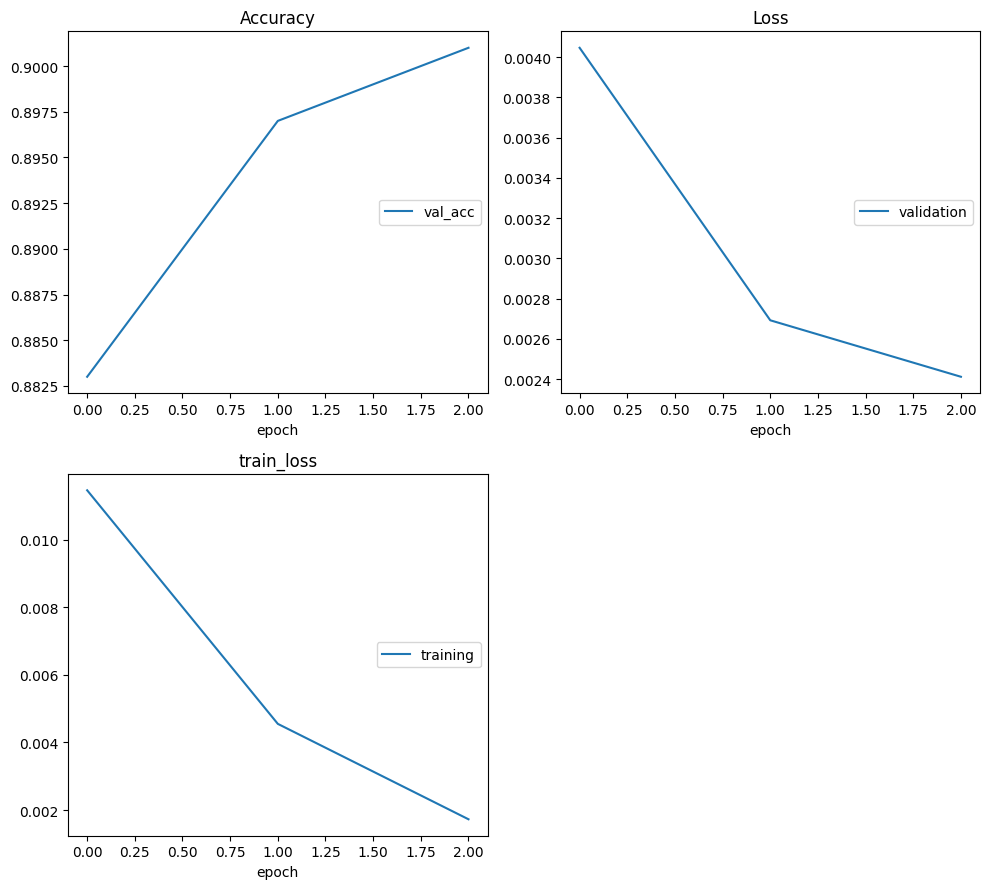

In [ ]:
N_EPOCHS = 15
BATCH_SIZE = 50
PRED_SIZE = 100
LEARNING_RATE = 0.01

model = FFNNBow(VOCAB_SIZE, NUM_LABELS, 5).to(device)
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.NLLLoss().to(device)

try:
    train_adv(train_dataset, dev_dataset,
              model, optimizer,
              generate_batch_bow,
              loss_function,
              bs=BATCH_SIZE,
              pred_bs=PRED_SIZE,
              scheduler=None,
              draw=True)
except KeyboardInterrupt:
    pass

test_loss, test_acc = test_adv(test_dataset, model,
                               generate_batch_bow,
                               loss_function, PRED_SIZE)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
# We will use early stopping for preventing the overfitting.
# In the real-world scentario, we would like to also track the best model and restore it, when
# the validation performance was at maximum.

N_EPOCHS = 15
BATCH_SIZE = 50
PRED_SIZE = 100
LEARNING_RATE = 0.01

model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.NLLLoss().to(device)

try:
    train_adv(train_dataset, dev_dataset,
            model, optimizer,
            generate_batch_bow,
            loss_function,
            bs=BATCH_SIZE,
            pred_bs=PRED_SIZE,
            scheduler=None,
            draw=True,
            tol=1)
except KeyboardInterrupt:
    pass


test_loss, test_acc = test_adv(test_dataset, model,
                               generate_batch_bow,
                               loss_function, PRED_SIZE)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
# Training with smaller learning rate can help to fit model better. But
# if we train with small learning rates we also need smaller batch size (so we use batch_size=5).
# This all results in a very slow training process.

N_EPOCHS = 5
BATCH_SIZE = 5
PRED_SIZE = 100
LEARNING_RATE = 0.0001

model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.NLLLoss().to(device)

try:
    train_adv(train_dataset,
            dev_dataset,
            model,
            optimizer,
            generate_batch_bow,
            loss_function,
            bs=BATCH_SIZE,
            pred_bs=PRED_SIZE,
            scheduler=None,
            draw=True,
            tol=1)
except KeyboardInterrupt:
    pass


test_loss, test_acc = test_adv(test_dataset, model,
                               generate_batch_bow,
                               loss_function, PRED_SIZE)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

In [ ]:
# It is better to use learning rate scheduler. We start from a big learning rate
# for faster convergence and closer to the end of the process we reduce LR to a small value

N_EPOCHS = 15
BATCH_SIZE = 50
PRED_SIZE = 100
LEARNING_RATE = 0.01

model = FFNNBow(VOCAB_SIZE, NUM_LABELS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
loss_function = nn.NLLLoss().to(device)

train_adv(train_dataset, dev_dataset,
          model, optimizer,
          generate_batch_bow, loss_function,
          bs=BATCH_SIZE, pred_bs=PRED_SIZE,
          scheduler=scheduler, draw=True, tol=5)

test_loss, test_acc = test_adv(test_dataset, model,
                               generate_batch_bow,
                               loss_function, PRED_SIZE)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

## Model with embeddings

In [52]:
class FFNNEmbedding(nn.Module):
    def __init__(self, vocab_size, num_class, embed_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)


def generate_batch_emb(batch):
    texts = [inst for _, inst in batch]
    offsets = [0] + [len(text) for text in texts]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    labels = torch.tensor([label for label, _ in batch])
    texts =  torch.cat(tuple(torch.tensor(e) for e in texts))
    return labels, (texts, offsets)

In [53]:
EMBED_DIM = 20

model = FFNNEmbedding(VOCAB_SIZE, NUM_LABELS, EMBED_DIM)
print('Number of parameters', count_parameters(model))
print(count_parameters(model.fc))
print(count_parameters(model.embedding))

Number of parameters 451122
42
451080


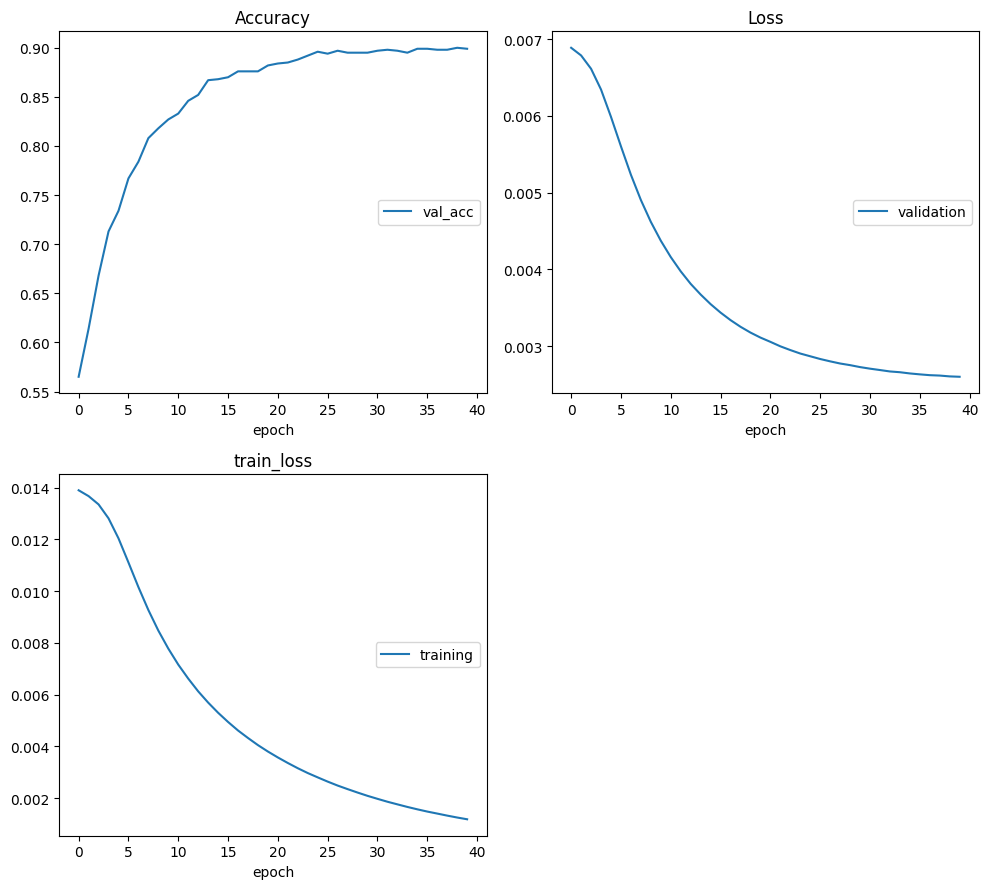

Accuracy
	val_acc          	 (min:    0.565, max:    0.900, cur:    0.899)
Loss
	validation       	 (min:    0.003, max:    0.007, cur:    0.003)
train_loss
	training         	 (min:    0.001, max:    0.014, cur:    0.001)
Finished training.


  0%|          | 0/40 [00:00<?, ?it/s]

Test loss: 0.0027338577955961225
Test accuracy: 0.89375


In [54]:
N_EPOCHS = 40
EMBED_DIM = 20
BATCH_SIZE = 50
PRED_SIZE = 100
LEARNING_RATE = 0.001

model = FFNNEmbedding(VOCAB_SIZE, NUM_LABELS, EMBED_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1)
loss_function = nn.CrossEntropyLoss().to(device)

train_adv(train_dataset, dev_dataset,
          model, optimizer,
          generate_batch_emb, loss_function,
          bs=BATCH_SIZE, pred_bs=PRED_SIZE,
          scheduler=scheduler, draw=True, tol=3)

test_loss, test_acc = test_adv(test_dataset, model,
                               generate_batch_emb,
                               loss_function, PRED_SIZE)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

# Other tips to incorporate in your deep learning pipeline

1. Gradient normalization and clipping.
2. Stochastic weight averaging / exponential weight averaging.
3. Batch normalization in the model and other types of normalizaiton.
4. Keep track of the best model on the validation set and restore it when you are doing annealing and at the end.

# Allennlp



## Simple model

In [55]:
from allennlp.models import BasicClassifier
from allennlp.data.dataset_readers import DatasetReader
from allennlp.data.fields import TextField, LabelField
from allennlp.data import Token, Instance

from nltk.tokenize import TweetTokenizer

from typing import Iterable


class ClassificationCsvReader(DatasetReader):
    def __init__(self, text_col, label_col, indexer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tokenizer = TweetTokenizer()
        self.token_indexers = {'tokens' : indexer}
        self._label_col = label_col
        self._text_col = text_col

    def _read(self, file_path: str) -> Iterable[Instance]:
        dataframe = pd.read_csv(file_path, header=None,
                                names=[self._label_col, self._text_col])

        for i in dataframe.index:
            yield self.text_to_instance(dataframe.loc[i, self._text_col],
                                        str(dataframe.loc[i, self._label_col]))

    def text_to_instance(self, text, target):
        text_field = TextField([Token(e.lower()) for e in self.tokenizer.tokenize(text)],
                                   self.token_indexers)
        label_field = LabelField(target)
        fields = {'tokens': text_field, 'label': label_field}
        return Instance(fields)

In [56]:
from itertools import islice
from pathlib import Path

from allennlp.data.token_indexers import SingleIdTokenIndexer


indexer = SingleIdTokenIndexer()

text_col = 'text'
label_col = 'label'
reader = ClassificationCsvReader(label_col=label_col, text_col=text_col, indexer=indexer)

train_dataset = reader.read(Path(DATA_PATH) / dataset_name / 'train.csv')
test_dataset = reader.read(Path(DATA_PATH) / dataset_name / 'test.csv')

train_dataset = list(tqdm(islice(train_dataset, 4000)))
test_dataset = list(tqdm(islice(test_dataset, 4000)))

print(next(iter(train_dataset)))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Instance with fields:
 	 tokens: TextField of length 130 with text: 
 		[unfortunately, ,, the, frustration, of, being, dr, ., goldberg's, patient, is, a, repeat, of, the,
		experience, i've, had, with, so, many, other, doctors, in, nyc, -, -, good, doctor, ,, terrible,
		staff, ., it, seems, that, his, staff, simply, never, answers, the, phone, ., it, usually, takes, 2,
		hours, of, repeated, calling, to, get, an, answer, ., who, has, time, for, that, or, wants, to,
		deal, with, it, ?, i, have, run, into, this, problem, with, many, other, doctors, and, i, just,
		don't, get, it, ., you, have, office, workers, ,, you, have, patients, with, medical, needs, ,, why,
		isn't, anyone, answering, the, phone, ?, it's, incomprehensible, and, not, work, the, aggravation,
		., it's, with, regret, that, i, feel, that, i, have, to, give, dr, ., goldberg, 2, stars, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: 1 in namespace: 'labels'. 



In [57]:
from allennlp.data.vocabulary import Vocabulary

vocab = Vocabulary.from_instances(train_dataset, min_count={"tokens": 1})
print('Vocabulary size:', vocab.get_vocab_size('tokens'))

building vocab: 100%|##########| 4000/4000 [00:00<00:00, 6803.74it/s]


Vocabulary size: 20987


In [58]:
from allennlp.training import GradientDescentTrainer
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.seq2vec_encoders import BagOfEmbeddingsEncoder

EMBEDDING_DIM = 20

embedder = Embedding(embedding_dim=EMBEDDING_DIM, vocab=vocab)
text_field_embedder = BasicTextFieldEmbedder({'tokens': embedder})
encoder = BagOfEmbeddingsEncoder(embedding_dim=EMBEDDING_DIM, averaged=True)
model = BasicClassifier(vocab,
                        text_field_embedder=text_field_embedder,
                        seq2vec_encoder=encoder,
                        dropout=0.1,
                        num_labels=vocab.get_vocab_size('labels'))
model = model.to(device)
print('Number of paramters:', count_parameters(model))
model

Number of paramters: 419782


BasicClassifier(
  (_text_field_embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (_seq2vec_encoder): BagOfEmbeddingsEncoder()
  (_dropout): Dropout(p=0.1, inplace=False)
  (_classification_layer): Linear(in_features=20, out_features=2, bias=True)
  (_loss): CrossEntropyLoss()
)

In [59]:
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.training.learning_rate_schedulers import ReduceOnPlateauLearningRateScheduler


optimizer = optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-6,
)

train_data_loader = SimpleDataLoader(
    instances=train_dataset, batch_size=50
)
train_data_loader.index_with(vocab)

test_data_loader = SimpleDataLoader(
    instances=test_dataset, batch_size=200
)
test_data_loader.index_with(vocab)


lr_scheduler = ReduceOnPlateauLearningRateScheduler(optimizer, factor=0.5, patience=1)

trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_data_loader,
    validation_data_loader=test_data_loader,
    num_epochs=40,
    cuda_device=device,
    learning_rate_scheduler=lr_scheduler,
    num_gradient_accumulation_steps=1,
    serialization_dir=None,
    patience=3
)

try:
    metrics = trainer.train()
except KeyboardInterrupt:
    pass

accuracy: 0.6857, batch_loss: 0.3354, loss: 0.5981 ||: 100%|##########| 80/80 [00:00<00:00, 183.38it/s]
accuracy: 0.8243, batch_loss: 0.4245, loss: 0.4154 ||: 100%|##########| 20/20 [00:00<00:00, 92.79it/s] 
accuracy: 0.8998, batch_loss: 0.1831, loss: 0.2920 ||: 100%|##########| 80/80 [00:00<00:00, 179.64it/s]
accuracy: 0.8812, batch_loss: 0.3058, loss: 0.2935 ||: 100%|##########| 20/20 [00:00<00:00, 93.94it/s] 
accuracy: 0.9583, batch_loss: 0.1036, loss: 0.1608 ||: 100%|##########| 80/80 [00:00<00:00, 187.67it/s]
accuracy: 0.8875, batch_loss: 0.2938, loss: 0.2799 ||: 100%|##########| 20/20 [00:00<00:00, 91.53it/s]
accuracy: 0.9802, batch_loss: 0.0824, loss: 0.0972 ||: 100%|##########| 80/80 [00:00<00:00, 181.48it/s]
accuracy: 0.8912, batch_loss: 0.2933, loss: 0.2782 ||: 100%|##########| 20/20 [00:00<00:00, 92.48it/s]
accuracy: 0.9902, batch_loss: 0.0654, loss: 0.0746 ||: 100%|##########| 80/80 [00:00<00:00, 183.68it/s]
accuracy: 0.8945, batch_loss: 0.2979, loss: 0.2817 ||: 100%|######

In [60]:
from allennlp.training.util import evaluate

evaluate(model, test_data_loader, cuda_device=device)

accuracy: 0.89, loss: 0.28 ||: : 20it [00:00, 95.32it/s]


{'accuracy': 0.89125, 'loss': 0.27816302627325057}

# Quick tip: In case of insufficient CUDA memory error

In [61]:
import gc
gc.collect()
torch.cuda.empty_cache()